# Modeling Work

Dear god the other file is borked and ugly to look at with all the EDA, will be moving over strictly the modeling here

In [1]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

Creating df to use

In [3]:
ft_df = pd.read_csv("../data/training_set_features.csv")
lbl_df = pd.read_csv("../data/training_set_labels.csv")
## Merging dfs
df_merged = ft_df.merge(lbl_df)
## Dropping:

# respondent_id: its just ids
# employment_occupation/industry: too many nulls, assuming imputing with most freq will give us wrong data
df_noid = df_merged.drop(['respondent_id','employment_occupation','employment_industry'], axis = 1)

In [4]:
# preparing X and y
X = df_noid.drop('h1n1_vaccine', axis = 1)
y = df_noid['h1n1_vaccine']

In [5]:
# initial split between test and rest. Final untouced data will be X_test/y_test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
# Splitting again for cross validation. X_train/X_valid will be used mostly
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, random_state = 42)

In [6]:
print(f"Sum of X_'s: {len(X_test)+len(X_train)+len(X_valid)}")
print(f"Length of df: {len(df_noid)}")

# Just checking if logic of trian/test/split worked correctly

Sum of X_'s: 26707
Length of df: 26707


In [7]:
df_noid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [8]:
# Every feature has some kind of null. Will have to impute first.
# Making pipelines for imputers
# Will also scale here

subpipe_num = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy = 'median')),
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps = [
    ('cat_impute', SimpleImputer(strategy = 'most_frequent')),
    
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])

In [9]:
# Col transformer will handle preprocessing
# Add model at end of the pipeline

CT = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, selector(dtype_include = np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include = object))
], remainder = 'passthrough')

In [10]:
test_model_pipe = Pipeline(steps = [
    ('ct', CT)
])


In [11]:
df_numeric = df_noid.select_dtypes(include=np.number)

In [12]:
df_categ = df_noid.select_dtypes(include = 'object')

In [13]:
#ohe encoder
ohe = OneHotEncoder(drop='first', sparse = False)
#inpute null vals with most freq
imputer = SimpleImputer(strategy = 'most_frequent')

imputer.fit(df_categ)
#transform by imputing then ohe
dummy = imputer.transform(df_categ)
dummy_df = pd.DataFrame(dummy, columns=df_categ.columns)
#dummy_df.info()
# ohe
ohe.fit(dummy_df)

OneHotEncoder(drop='first', sparse=False)

In [14]:
dummy2 = ohe.transform(dummy_df)
dummy_df2 = pd.DataFrame(dummy2, columns=ohe.get_feature_names())
dummy_df2

,x0_35 - 44 Years,x0_45 - 54 Years,x0_55 - 64 Years,x0_65+ Years,x1_< 12 Years,x1_College Graduate,x1_Some College,x2_Hispanic,x2_Other or Multiple,x2_White,...,x8_dqpwygqj,x8_fpwskwrf,x8_kbazzjca,x8_lrircsnp,x8_lzgpxyit,x8_mlyzmhmf,x8_oxchjgsf,x8_qufhixun,"x9_MSA, Principle City",x9_Non-MSA
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
26703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
26704,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
26705,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
df_temp_comb = df_numeric.merge(dummy_df2, left_index = True, right_index = True)

In [16]:
df_temp_comb

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,x8_dqpwygqj,x8_fpwskwrf,x8_kbazzjca,x8_lrircsnp,x8_lzgpxyit,x8_mlyzmhmf,x8_oxchjgsf,x8_qufhixun,"x9_MSA, Principle City",x9_Non-MSA
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
num_impute =  SimpleImputer(strategy = 'median')

In [18]:
ss = StandardScaler()

In [19]:
imputed = num_impute.fit_transform(df_numeric)

In [20]:
scaled_imputed = ss.fit_transform(imputed)

In [21]:
scaled_imputed.shape

(26707, 25)

## First Dummy Model

In [22]:
dummy_model_pipe = Pipeline(steps = [
    ('ct',CT),
    ('dummy', DummyClassifier(strategy = 'most_frequent'))
])

In [23]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [24]:
dummy_model_pipe.score(X_train, y_train)

0.7851001275863981

CV Results for `dummy` model:
            0.78510 ± 0.00025 accuracy
        


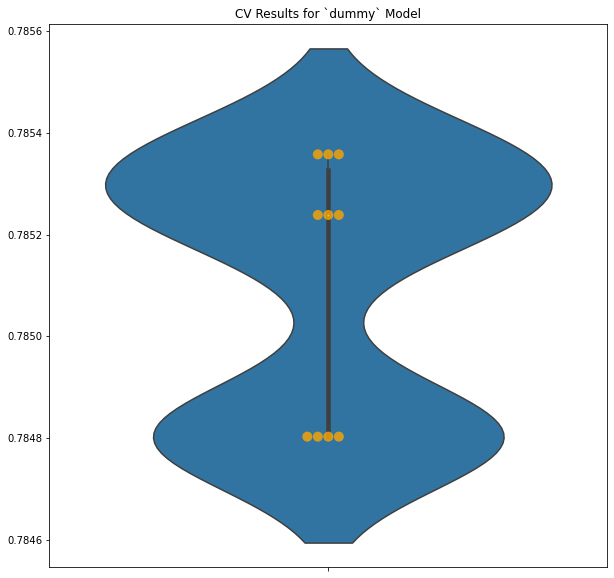

In [25]:
dummy_pipe = ModelWithCV(
    dummy_model_pipe,
model_name = 'dummy',
X = X_train,
y = y_train)
fig, ax = plt.subplots(figsize = (10,10))
dummy_pipe.plot_cv(ax=ax)
dummy_pipe.print_cv_summary()

In [26]:
dummy_model_pipe.score(X_valid, y_valid)

0.7956398735230488

In [27]:
y_pred = dummy_model_pipe.predict(X_valid)

In [28]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4781
           1       0.00      0.00      0.00      1228

    accuracy                           0.80      6009
   macro avg       0.40      0.50      0.44      6009
weighted avg       0.63      0.80      0.71      6009



F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


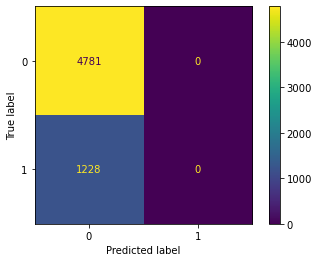

In [29]:
plot_confusion_matrix(dummy_model_pipe, X_valid, y_valid)

## Logreg model basic

In [30]:
logreg_basic_model_pipe = Pipeline(steps = [
    ('ct', CT),
    ('logreg_basic', LogisticRegression())
])

In [31]:
logreg_basic_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [32]:
logreg_basic_model_pipe.score(X_train, y_train)

0.8510567482110168

In [33]:
logreg_basic_model_pipe.score(X_valid, y_valid)

0.853719420868697

CV Results for `logreg_basic_with_cv` model:
            0.84934 ± 0.00733 accuracy
        


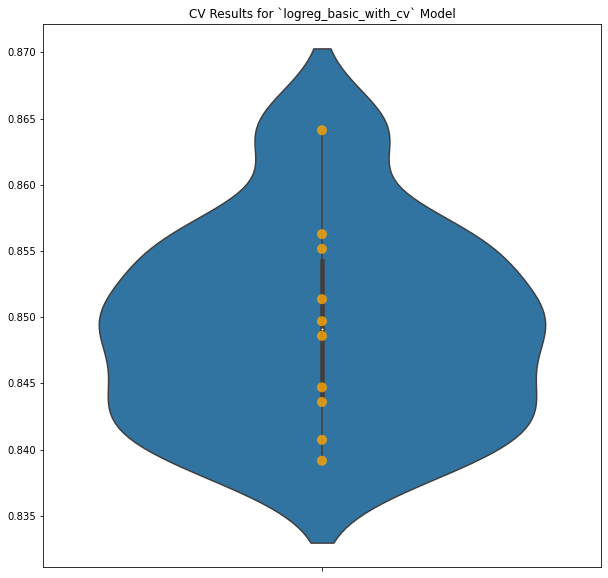

In [34]:
logreg_basic_cv = ModelWithCV(
    logreg_basic_model_pipe,
model_name = 'logreg_basic_with_cv',
X = X_train,
y = y_train)
fig, ax = plt.subplots(figsize = (10,10))
logreg_basic_cv.plot_cv(ax=ax)
logreg_basic_cv.print_cv_summary()

In [35]:
logreg_basic_model_pipe.score(X_valid, y_valid)

0.853719420868697

In [36]:
y_pred = logreg_basic_model_pipe.predict(X_valid)

In [37]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4781
           1       0.70      0.50      0.58      1228

    accuracy                           0.85      6009
   macro avg       0.79      0.72      0.75      6009
weighted avg       0.84      0.85      0.84      6009



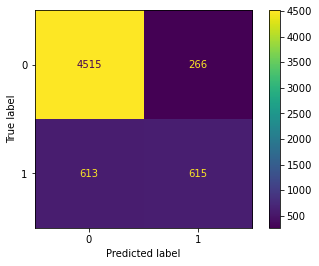

In [38]:
plot_confusion_matrix(logreg_basic_model_pipe, X_valid, y_valid)

Just looking at logreg basic (no hyperparams set), def an improvement over original dummy test. Will do decision tree basic next

## Decision Tree Basic Model

In [39]:
dtc_basic_model_pipe = Pipeline(steps=[
    ('ct', CT),  
    ('dtc', DecisionTreeClassifier())
])

In [40]:
dtc_basic_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

CV Results for `dtc_basic_with_cv` model:
            0.78116 ± 0.00947 accuracy
        


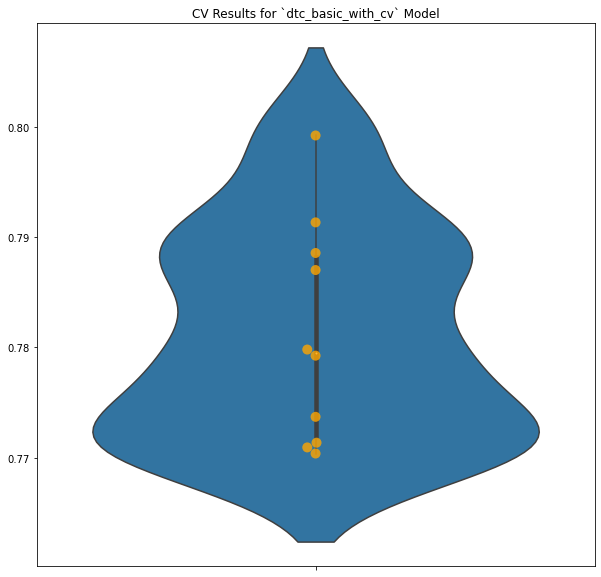

In [41]:
dtc_basic_cv = ModelWithCV(
    dtc_basic_model_pipe,
    model_name='dtc_basic_with_cv',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

dtc_basic_cv.plot_cv(ax=ax)
dtc_basic_cv.print_cv_summary()

In [42]:
dtc_basic_cv.print_cv_summary()

CV Results for `dtc_basic_with_cv` model:
            0.78116 ± 0.00947 accuracy
        


In [43]:
dtc_basic_model_pipe.score(X_valid, y_valid)

0.7794974205358629

In [44]:
y_pred = dtc_basic_model_pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4781
           1       0.46      0.50      0.48      1228

    accuracy                           0.78      6009
   macro avg       0.67      0.68      0.67      6009
weighted avg       0.79      0.78      0.78      6009



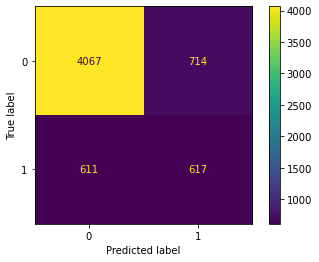

In [45]:
plot_confusion_matrix(dtc_basic_model_pipe, X_valid, y_valid)

### Overview so far with our 3 models

In [46]:
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()

In [47]:
model_list = [('dummy',dum_model), ('logreg_basic_cv',lr_model), ('dtc_basic_cv',tree_model)]

In [48]:
for name, model in model_list:
    loop_model_pipe = Pipeline(steps=[
        ('ct', CT),
        (name, model)
    ])
    
    loop_model_pipe.fit(X_train,y_train)
    
    loop_pipe = ModelWithCV(
        loop_model_pipe,
        model_name=name,
        X=X_valid,
        y=y_valid)
    
    loop_pipe.print_cv_summary()
    

CV Results for `dummy` model:
            0.79564 ± 0.00060 accuracy
        
CV Results for `logreg_basic_cv` model:
            0.85122 ± 0.00886 accuracy
        
CV Results for `dtc_basic_cv` model:
            0.78349 ± 0.01452 accuracy
        


Man, by default DTC is just worse. Will try to fine tune up DTC first to see if we can get anywhere. Else will fall back to logreg fine tuning instead.

## Attempting a random hypertune on logreg

In [49]:
logreg_model_pipe = Pipeline(steps = [
    ('ct', CT),
    ('logreg_model', LogisticRegression(penalty = 'l2', max_iter = 500, C = 0.1 ))
])

In [50]:
logreg_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

CV Results for `logreg_with_cv` model:
            0.84923 ± 0.00724 accuracy
        


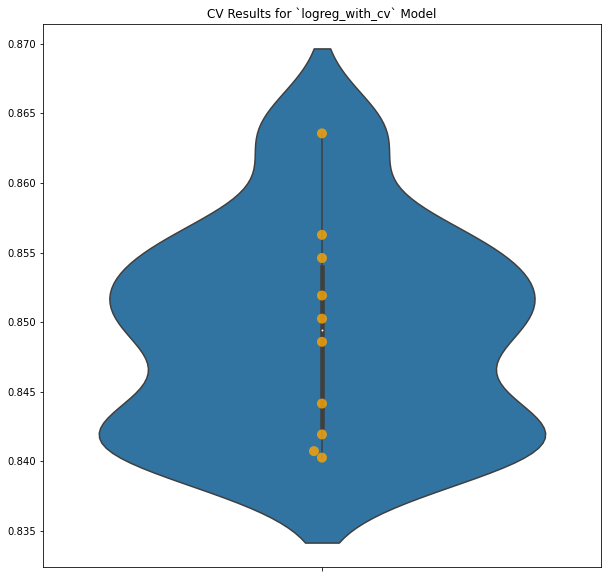

In [51]:
logreg_cv = ModelWithCV(
    logreg_model_pipe,
    model_name='logreg_with_cv',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

logreg_cv.plot_cv(ax=ax)
logreg_cv.print_cv_summary()

In [52]:
logreg_model_pipe.score(X_valid, y_valid)

0.853719420868697

In [53]:
y_pred = logreg_model_pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4781
           1       0.70      0.50      0.58      1228

    accuracy                           0.85      6009
   macro avg       0.79      0.72      0.75      6009
weighted avg       0.84      0.85      0.84      6009



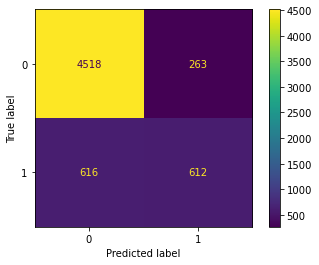

In [54]:
plot_confusion_matrix(logreg_model_pipe, X_valid, y_valid)

Just trying out a random hyperparameter. Didnt change much. Will start gridsearching now on dtc instead. I think hypertuning logreg will be a grind.

## Begin hypertuning on dt

In [55]:
y_train.value_counts(normalize = True)

0    0.7851
1    0.2149
Name: h1n1_vaccine, dtype: float64

Definitely unbalanced. Will try regression and decision tree again with balanced datasets
- Edit after meeting with David: 
    - So not that imbalanced out the gate, would consider this moderately imbalanced.
    - Will try to SMOTE getting the data closer to the milder proportion of balance.

In [56]:
dtc_smote_pipe = ImPipeline(steps = [
    ('ct', CT),
    ('sm', SMOTE(random_state = 42)),
    ('dtc_smote', DecisionTreeClassifier(random_state = 42))
])

In [57]:
dtc_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

CV Results for `dtc_smote_modelwithCV` model:
            0.77395 ± 0.00921 accuracy
        


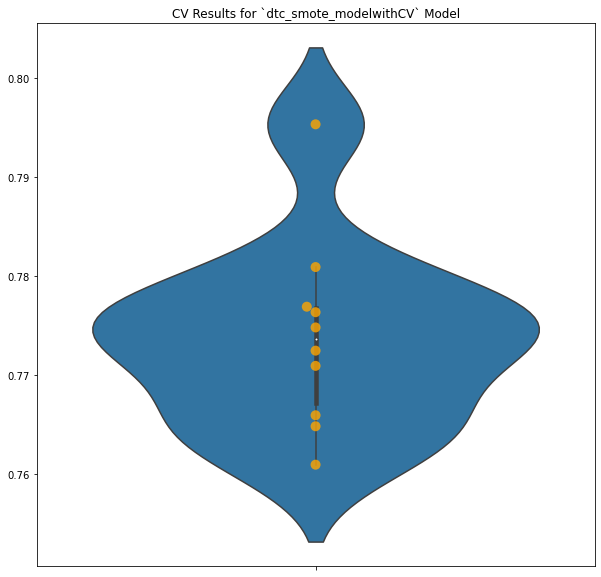

In [58]:
dtc_smote_cv = ModelWithCV(
    dtc_smote_pipe,
model_name = 'dtc_smote_modelwithCV',
X = X_train,
y = y_train)
fig, ax = plt.subplots(figsize = (10,10))
dtc_smote_cv.plot_cv(ax=ax)
dtc_smote_cv.print_cv_summary()

In [59]:
dtc_smote_pipe.score(X_valid, y_valid)

0.7706773173572974

In [60]:
y_pred = dtc_smote_pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4781
           1       0.45      0.49      0.47      1228

    accuracy                           0.77      6009
   macro avg       0.66      0.67      0.66      6009
weighted avg       0.78      0.77      0.78      6009



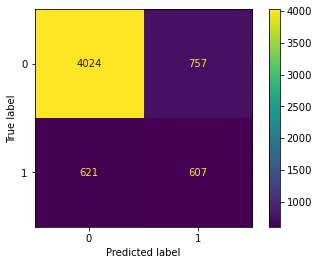

In [61]:
plot_confusion_matrix(dtc_smote_pipe, X_valid, y_valid)

Lol amazing, it got worse than basic dtc with no smote. But this may be because smote auto just makes it 50/50. Initially 20%~ considered mildly balanced. To make it moderately balanced will start smoting between sampling_strategy < 0.4287 < 0.6667 (30% and 40% of pop 1 respectively)



### Gridsearching with DTC

In [62]:
parameters = {'dtc_smote__criterion': ['gini'],
          'dtc_smote__min_samples_leaf': [ 40],
          'sm__k_neighbors': [ 3],
          'sm__sampling_strategy':[0.4435]}

#sampling_strategy = 0.4287
gs = GridSearchCV(estimator=dtc_smote_pipe,
                 param_grid=parameters,
                 cv=10)

In [63]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                                        ('subpipe_cat',
                                                                         Pip

In [64]:
gs.best_params_

{'dtc_smote__criterion': 'gini',
 'dtc_smote__min_samples_leaf': 40,
 'sm__k_neighbors': 3,
 'sm__sampling_strategy': 0.4435}

CV Results for `gs_dtc_model` model:
            0.83991 ± 0.00813 accuracy
        


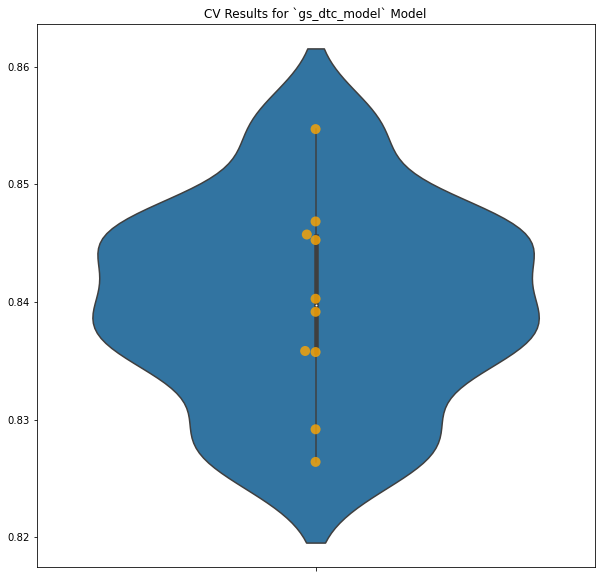

In [65]:
gs_pipe = ModelWithCV(
    gs.best_estimator_,
    model_name='gs_dtc_model',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

gs_pipe.plot_cv(ax=ax)
gs_pipe.print_cv_summary()

In [66]:
gs_pipe.print_cv_summary()

CV Results for `gs_dtc_model` model:
            0.83991 ± 0.00813 accuracy
        


In [67]:
gs.best_estimator_.score(X_valid, y_valid)

0.8410717257447162

In [68]:
y_pred = gs.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      4781
           1       0.63      0.54      0.58      1228

    accuracy                           0.84      6009
   macro avg       0.76      0.73      0.74      6009
weighted avg       0.83      0.84      0.84      6009



In [69]:
gs.best_estimator_.named_steps.dtc_smote.feature_importances_

array([9.07204715e-03, 2.65573251e-03, 4.59453633e-04, 1.85588393e-03,
       0.00000000e+00, 1.79994946e-03, 3.90817485e-03, 7.19816377e-04,
       1.10218447e-04, 2.22321992e-01, 6.69826163e-02, 1.65017334e-03,
       0.00000000e+00, 1.02392755e-02, 1.49895507e-05, 1.21100818e-01,
       4.44279324e-02, 7.87877145e-03, 2.90737862e-02, 7.62467412e-03,
       5.96985517e-03, 1.81204582e-03, 2.42596887e-03, 3.99278594e-01,
       9.19529562e-04, 1.90278868e-03, 4.34436273e-04, 1.91737491e-03,
       1.55839946e-03, 1.91284907e-03, 7.21610172e-04, 8.25742834e-03,
       1.53955973e-03, 0.00000000e+00, 0.00000000e+00, 1.18595199e-04,
       2.34275188e-03, 7.59198339e-04, 3.57462789e-03, 4.22289074e-03,
       4.37339945e-04, 0.00000000e+00, 2.64056438e-03, 1.51601168e-03,
       4.86216083e-04, 0.00000000e+00, 2.43391282e-03, 3.37655056e-04,
       0.00000000e+00, 1.78314332e-04, 1.42317008e-03, 0.00000000e+00,
       1.71292645e-03, 2.88472711e-04, 4.13770843e-05, 1.76450932e-03,
      

Iteration 2 Confusion Matrix


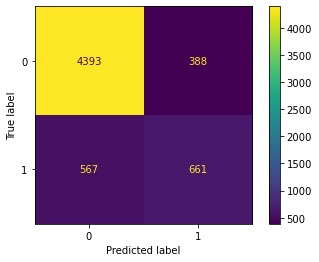

In [70]:
plot_confusion_matrix(gs.best_estimator_, X_valid, y_valid)
print(f"Iteration 2 Confusion Matrix")
#plt.savefig('Modeling_Work_1_Logreg_DTC_best.png')

Greatly improved from before. Will log the results in a separate notebook. 

But this still does not beat logreg. From this point will be gridsearching for logreg.

## Begin hypertuning on logreg

In [71]:
logreg_smote_pipe = ImPipeline(steps = [
    ('ct', CT),
    ('sm', SMOTE(random_state = 42)),
    ('logreg_smote', LogisticRegression(random_state = 42, max_iter = 500))
])

In [72]:
logreg_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

CV Results for `dtc_smote_modelwithCV` model:
            0.79531 ± 0.01021 accuracy
        


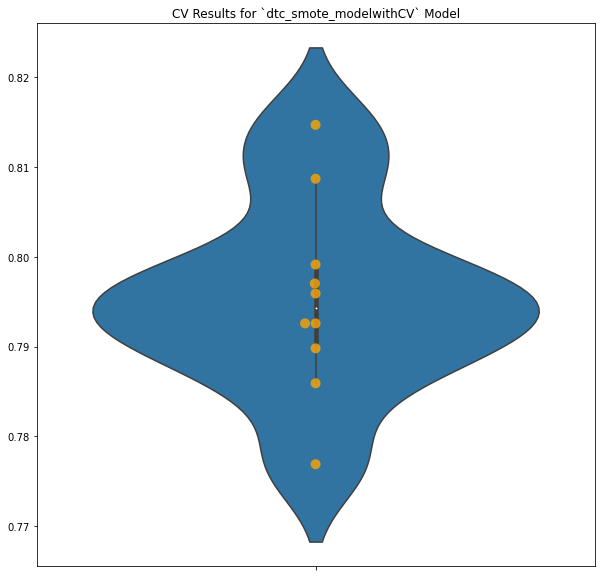

In [73]:
logreg_smote_cv = ModelWithCV(
    logreg_smote_pipe,
model_name = 'dtc_smote_modelwithCV',
X = X_train,
y = y_train)
fig, ax = plt.subplots(figsize = (10,10))
logreg_smote_cv.plot_cv(ax=ax)
logreg_smote_cv.print_cv_summary()

In [74]:
logreg_smote_pipe.score(X_valid, y_valid)

0.799966716591779

In [75]:
y_pred = logreg_smote_pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86      4781
           1       0.51      0.79      0.62      1228

    accuracy                           0.80      6009
   macro avg       0.72      0.80      0.74      6009
weighted avg       0.85      0.80      0.81      6009



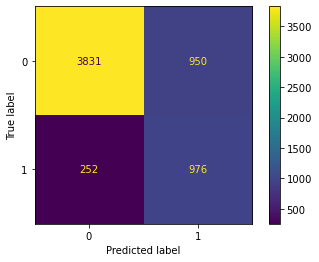

In [76]:
plot_confusion_matrix(logreg_smote_pipe, X_valid, y_valid)

Gross, smote made it much worse. Will go back to no smote at first and gridsearch on the base logreg model

### Gridsearch on logreg model

Redeclaring logreg base model again

In [77]:
logreg_basic_model_pipe = Pipeline(steps = [
    ('ct', CT),
    ('logreg_basic', LogisticRegression())
])
logreg_basic_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [78]:
params = {}
params['ct__subpipe_num__num_impute__strategy'] = ['median']
params['logreg_basic__penalty'] = ['l2'] 
params['logreg_basic__max_iter'] = [100]
params['logreg_basic__C'] = [0.035]

gs = GridSearchCV(estimator = logreg_basic_model_pipe,
               param_grid = params,
               cv = 10)

In [79]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000017A00AD0550>),
                                                                        ('subpipe_cat',
                                                                         Pip

In [80]:
gs.best_params_

{'ct__subpipe_num__num_impute__strategy': 'median',
 'logreg_basic__C': 0.035,
 'logreg_basic__max_iter': 100,
 'logreg_basic__penalty': 'l2'}

CV Results for `gs_dtc_model` model:
            0.84967 ± 0.00744 accuracy
        


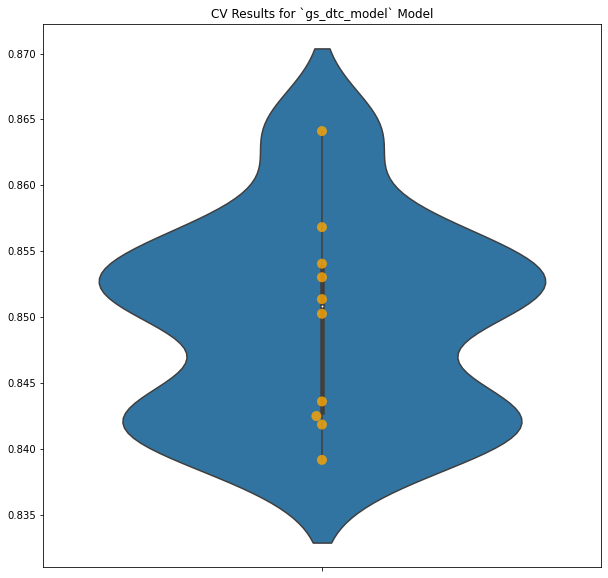

In [81]:
gs_pipe = ModelWithCV(
    gs.best_estimator_,
    model_name='gs_dtc_model',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

gs_pipe.plot_cv(ax=ax)
gs_pipe.print_cv_summary()

In [82]:
gs_pipe.print_cv_summary()

CV Results for `gs_dtc_model` model:
            0.84967 ± 0.00744 accuracy
        


In [83]:
gs.best_estimator_.score(X_valid, y_valid)

0.8528873356631719

In [84]:
y_pred = gs.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4781
           1       0.70      0.49      0.58      1228

    accuracy                           0.85      6009
   macro avg       0.79      0.72      0.74      6009
weighted avg       0.84      0.85      0.84      6009



In [85]:
best_model = gs.best_estimator_

In [86]:
best_model.named_steps.logreg_basic.tol

0.0001

In [87]:
gs.best_estimator_.named_steps.logreg_basic.tol

0.0001

In [88]:
best_model.named_steps.logreg_basic.coef_

array([[-0.0723281 ,  0.0098455 ,  0.03956356, -0.01766306,  0.05310661,
        -0.01753381, -0.07337798, -0.02429055, -0.01017203,  0.86978956,
        -0.3883767 , -0.00598581,  0.06590209,  0.20044921, -0.01700976,
         0.61144331,  0.49051983, -0.0055145 , -0.12265591, -0.01402477,
        -0.05010092,  0.00664987, -0.0402725 ,  0.97781643,  0.10888562,
        -0.07744296, -0.0895847 ,  0.04013185,  0.01793664,  0.03398938,
        -0.13923701,  0.09230832,  0.01286577, -0.11741798,  0.00178826,
         0.10985876,  0.00569741, -0.10247265,  0.10239911, -0.01745768,
        -0.00908643,  0.02647057,  0.03941717, -0.03949071,  0.02501589,
        -0.02508944, -0.03636173, -0.00532794,  0.04161612, -0.05848359,
         0.02948557, -0.10139754, -0.0772773 , -0.11931135,  0.12514841,
        -0.12598854,  0.2287121 ,  0.03398431,  0.0650544 , -0.04526954,
         0.03860736,  0.00658863]])

In [89]:
gs.best_estimator_.named_steps.logreg_basic.tol

0.0001

In [90]:
#gs.best_estimator_.named_steps.dtc_smote.feature_importances_

## Overall summary so far:

Did DTC and Logreg model 1 first in this workbook. Model 2 DTC and Logreg are on other notebooks. Conclusion at end of notebook: "Modeling_Work_3_DTC"